# Model C: Deterministic Hazard Model / Cox Regression

This notebook implements **Model C** from the proposal: a deterministic hazard model and/or empirical Cox regression for age-dependent cancer risk.

## Overview

This model uses a deterministic hazard function approach, where the cancer risk is modeled as a continuous hazard rate that accumulates over time. The model uses the **lifelines** library for survival analysis and Cox regression.

## References

- **Cox, D. R. (1972)**: "Regression Models and Life-Tables", Journal of the Royal Statistical Society, Series B, 34(2), 187-220
- **lifelines Library**: Davidson-Pilon, C. (2019). lifelines: survival analysis in Python. Journal of Open Source Software, 4(40), 1317.
  - GitHub: https://github.com/CamDavidsonPilon/lifelines
  - Documentation: https://lifelines.readthedocs.io/

## Method

1. Define deterministic hazard function: $h(t) = \lambda \cdot t^k$ or exponential form
2. Calculate cumulative hazard: $H(t) = \int_0^t h(s) ds$
3. Convert to survival function: $S(t) = \exp(-H(t))$
4. Calculate incidence: $I(t) = 1 - S(t)$
5. Use lifelines library for Weibull, Exponential, and other parametric models
6. Optionally fit Cox regression for empirical parameter estimation


In [ ]:
# Import libraries
import sys
from pathlib import Path
import importlib

# Add project root to path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Import lifelines library for survival analysis
try:
    from lifelines import WeibullFitter, ExponentialFitter
    from lifelines.statistics import logrank_test
    LIFELINES_AVAILABLE = True
    print("✓ lifelines library imported successfully!")
except ImportError:
    LIFELINES_AVAILABLE = False
    print("⚠ Warning: lifelines library not found. Install with: pip install lifelines")
    print("  Falling back to scipy-based implementation.")

# Import project modules
from src.data_loader import load_uscs_data, prepare_all_sites_age_data
from src.utils import age_group_to_mid

# Set style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 11

print("✓ All modules imported successfully!")


⚠ Warning: lifelines library not found. Install with: pip install lifelines
  Falling back to scipy-based implementation.
✓ All modules imported successfully!


## Data Sources: USCS (current) and TCGA (planned)

This notebook currently fits deterministic hazard and regression models to age–incidence curves derived from **USCS (U.S. Cancer Statistics)** tables in `data/USCS-1999-2022-ASCII/`.

TCGA (The Cancer Genome Atlas) data under `data/TCGA/` is planned for future extensions, for example to provide tumor-level survival and mutation burden information that can be linked to the age-dependent hazard patterns modeled here.


## 1. Load and Prepare Data


In [2]:
# Load USCS data
print("Loading USCS data...")
brain_by_site, by_age = load_uscs_data()

# Prepare age-specific incidence data
all_sites_age_inc = prepare_all_sites_age_data(by_age)

print(f"✓ Age-specific incidence records: {all_sites_age_inc.shape[0]}")


Loading USCS data...
✓ Age-specific incidence records: 1350


## 2. Prepare Age-Incidence Data


In [3]:
# Prepare age-incidence data for 2020
TARGET_YEAR = 2020

# Filter for target year
age_model_df = all_sites_age_inc.copy()
age_model_df["AGE_MID"] = age_model_df["AGE"].apply(age_group_to_mid)
age_model_df = age_model_df[age_model_df["AGE_MID"].notna()].copy()

age_year_df = age_model_df[
    pd.to_numeric(age_model_df["YEAR"], errors="coerce") == TARGET_YEAR
].copy()
age_year_df = age_year_df.sort_values("AGE_MID")

# Get ages and rates
ages = age_year_df["AGE_MID"].values
rates = age_year_df["RATE"].values

print(f"✓ Data points: {len(ages)} age groups")
print(f"✓ Age range: {ages.min():.1f} - {ages.max():.1f} years")
print(f"✓ Incidence range: {rates.min():.1f} - {rates.max():.1f} per 100,000")


✓ Data points: 54 age groups
✓ Age range: 2.5 - 87.5 years
✓ Incidence range: 11.4 - 2788.5 per 100,000


## 3. Implement Deterministic Hazard Model

The deterministic hazard model uses a hazard function $h(t)$ that describes the instantaneous risk of cancer at age $t$.

Common forms:
- **Power-law hazard**: $h(t) = \lambda \\cdot t^k$
- **Exponential hazard**: $h(t) = \lambda \\cdot e^{\\beta t}$
- **Weibull hazard**: $h(t) = \\frac{k}{\\lambda} \\left(\\frac{t}{\\lambda}\\right)^{k-1}$

The cumulative hazard is: $H(t) = \\int_0^t h(s) ds$

And the incidence (cumulative risk) is: $I(t) = 1 - \\exp(-H(t))$


In [4]:
# Use lifelines library for parametric survival models when available
# Fallback to custom implementation for power-law hazard

class DeterministicHazardModel:
    """
    Deterministic hazard model for age-dependent cancer risk.
    
    Uses hazard function h(t) to model instantaneous risk, then integrates
    to get cumulative hazard H(t) and converts to incidence I(t) = 1 - exp(-H(t)).
    
    For Weibull and Exponential models, uses lifelines library (official implementation).
    For power-law hazard, uses custom scipy-based implementation.
    """
    
    def __init__(self, hazard_type='power_law'):
        """
        Initialize the deterministic hazard model.
        
        Parameters
        ----------
        hazard_type : str, default='power_law'
            Type of hazard function: 'power_law', 'exponential', or 'weibull'
            'weibull' and 'exponential' use lifelines library if available
        """
        self.hazard_type = hazard_type
        self.params = None
        self.model_func = None
        self.lifelines_fitter = None  # Store lifelines fitter if used
    
    def _power_law_hazard(self, t, lambda_param, k):
        """Power-law hazard: h(t) = lambda * t^k"""
        return lambda_param * (t ** k)
    
    def _exponential_hazard(self, t, lambda_param, beta):
        """Exponential hazard: h(t) = lambda * exp(beta * t)"""
        return lambda_param * np.exp(beta * t)
    
    def _weibull_hazard(self, t, lambda_param, k):
        """Weibull hazard: h(t) = (k/lambda) * (t/lambda)^(k-1)"""
        return (k / lambda_param) * ((t / lambda_param) ** (k - 1))
    
    def _power_law_cumulative_hazard(self, t, lambda_param, k):
        """Cumulative hazard for power-law: H(t) = lambda * t^(k+1) / (k+1)"""
        return lambda_param * (t ** (k + 1)) / (k + 1)
    
    def _exponential_cumulative_hazard(self, t, lambda_param, beta):
        """Cumulative hazard for exponential: H(t) = (lambda/beta) * (exp(beta*t) - 1)"""
        if abs(beta) < 1e-10:
            return lambda_param * t
        return (lambda_param / beta) * (np.exp(beta * t) - 1)
    
    def _weibull_cumulative_hazard(self, t, lambda_param, k):
        """Cumulative hazard for Weibull: H(t) = (t/lambda)^k"""
        return (t / lambda_param) ** k
    
    def fit(self, ages, rates, initial_params=None):
        """
        Fit the hazard model to observed incidence data.
        
        Parameters
        ----------
        ages : array-like
            Ages in years.
        rates : array-like
            Incidence rates (per 100,000).
        initial_params : array-like, optional
            Initial parameter guesses for optimization.
        """
        ages = np.asarray(ages)
        rates = np.asarray(rates)
        
        # Convert rates to probabilities (divide by 100,000)
        probabilities = rates / 100000.0
        
        # Filter valid data
        valid_mask = (ages > 0) & (probabilities > 0) & (probabilities < 1)
        ages_valid = ages[valid_mask]
        probs_valid = probabilities[valid_mask]
        
        # Define model function based on hazard type
        if self.hazard_type == 'power_law':
            def model_func(t, lambda_param, k):
                H = self._power_law_cumulative_hazard(t, lambda_param, k)
                return 1 - np.exp(-H)
            
            if initial_params is None:
                initial_params = [1e-6, 2.0]  # [lambda, k]
        
        elif self.hazard_type == 'exponential':
            def model_func(t, lambda_param, beta):
                H = self._exponential_cumulative_hazard(t, lambda_param, beta)
                return 1 - np.exp(-H)
            
            if initial_params is None:
                initial_params = [1e-6, 0.05]  # [lambda, beta]
        
        elif self.hazard_type == 'weibull':
            # Try to use lifelines WeibullFitter if available
            if LIFELINES_AVAILABLE:
                try:
                    from lifelines import WeibullFitter
                    # Create synthetic survival data from incidence rates
                    synthetic_durations = []
                    synthetic_events = []
                    
                    for age, rate in zip(ages_valid, probs_valid * 100000):
                        prob = rate / 100000.0
                        n_obs = max(1, int(prob * 1000))
                        synthetic_durations.extend([age] * n_obs)
                        synthetic_events.extend([1] * n_obs)
                    
                    if len(synthetic_durations) > 0:
                        wf = WeibullFitter()
                        wf.fit(synthetic_durations, synthetic_events)
                        self.lifelines_fitter = wf
                        # Extract parameters: lambda_ (scale) and rho_ (shape)
                        self.params = np.array([wf.lambda_, wf.rho_])
                        self.model_func = None  # Will use lifelines for prediction
                        return self
                except Exception as e:
                    print(f"Warning: lifelines Weibull fitting failed: {e}, using scipy")
            
            # Fallback to scipy-based implementation
            def model_func(t, lambda_param, k):
                H = self._weibull_cumulative_hazard(t, lambda_param, k)
                return 1 - np.exp(-H)
            
            if initial_params is None:
                initial_params = [50.0, 2.0]  # [lambda, k]
        
        elif self.hazard_type == 'exponential':
            # Try to use lifelines ExponentialFitter if available
            if LIFELINES_AVAILABLE:
                try:
                    from lifelines import ExponentialFitter
                    # Create synthetic survival data
                    synthetic_durations = []
                    synthetic_events = []
                    
                    for age, rate in zip(ages_valid, probs_valid * 100000):
                        prob = rate / 100000.0
                        n_obs = max(1, int(prob * 1000))
                        synthetic_durations.extend([age] * n_obs)
                        synthetic_events.extend([1] * n_obs)
                    
                    if len(synthetic_durations) > 0:
                        ef = ExponentialFitter()
                        ef.fit(synthetic_durations, synthetic_events)
                        self.lifelines_fitter = ef
                        # Extract lambda parameter
                        self.params = np.array([ef.lambda_, 0.0])  # beta not used in exponential
                        self.model_func = None
                        return self
                except Exception as e:
                    print(f"Warning: lifelines Exponential fitting failed: {e}, using scipy")
            
            # Fallback to scipy-based implementation
            def model_func(t, lambda_param, beta):
                H = self._exponential_cumulative_hazard(t, lambda_param, beta)
                return 1 - np.exp(-H)
            
            if initial_params is None:
                initial_params = [1e-6, 0.05]  # [lambda, beta]
        
        else:
            raise ValueError(f"Unknown hazard_type: {self.hazard_type}")
        
        self.model_func = model_func
        
        # Fit using curve_fit (for power_law or fallback)
        try:
            popt, _ = curve_fit(
                model_func,
                ages_valid,
                probs_valid,
                p0=initial_params,
                maxfev=10000,
                bounds=(0, np.inf)
            )
            self.params = popt
        except Exception as e:
            print(f"Warning: Fitting failed with error: {e}")
            print("Using initial parameters as defaults.")
            self.params = initial_params
        
        return self
    
    def predict(self, ages):
        """
        Predict incidence rates for given ages.
        
        Parameters
        ----------
        ages : array-like
            Ages in years.
        
        Returns
        -------
        array
            Predicted incidence probabilities (convert to rates by multiplying by 100,000).
        """
        if self.params is None:
            raise ValueError("Model must be fitted before prediction.")
        
        ages = np.asarray(ages)
        
        # Use lifelines fitter if available
        if self.lifelines_fitter is not None:
            # Get cumulative hazard from lifelines
            cumulative_hazard = self.lifelines_fitter.cumulative_hazard_at_times(ages)
            # Convert to incidence: I(t) = 1 - exp(-H(t))
            probs = 1 - np.exp(-cumulative_hazard.values.flatten())
        elif self.model_func is not None:
            probs = self.model_func(ages, *self.params)
        else:
            raise ValueError("Model not properly fitted.")
        
        # Convert probabilities back to rates (per 100,000)
        return probs * 100000.0
    
    def get_parameters(self):
        """Return model parameters."""
        if self.params is None:
            return None
        
        if self.hazard_type == 'power_law':
            return {
                'lambda': self.params[0],
                'k': self.params[1],
                'hazard_type': self.hazard_type
            }
        elif self.hazard_type == 'exponential':
            return {
                'lambda': self.params[0],
                'beta': self.params[1],
                'hazard_type': self.hazard_type
            }
        elif self.hazard_type == 'weibull':
            if self.lifelines_fitter is not None:
                # lifelines uses lambda_ (scale) and rho_ (shape)
                return {
                    'lambda': self.lifelines_fitter.lambda_,
                    'k': self.lifelines_fitter.rho_,
                    'hazard_type': self.hazard_type,
                    'method': 'lifelines'
                }
            else:
                return {
                    'lambda': self.params[0],
                    'k': self.params[1],
                    'hazard_type': self.hazard_type,
                    'method': 'scipy'
                }
        elif self.hazard_type == 'exponential':
            if self.lifelines_fitter is not None:
                return {
                    'lambda': self.lifelines_fitter.lambda_,
                    'hazard_type': self.hazard_type,
                    'method': 'lifelines'
                }
            else:
                return {
                    'lambda': self.params[0],
                    'beta': self.params[1],
                    'hazard_type': self.hazard_type,
                    'method': 'scipy'
                }


## 4. Alternative Implementation Using lifelines Library

The `lifelines` library provides robust implementations of survival analysis models. We can use it as an alternative or complement to our custom implementation.


In [5]:
# Alternative implementation using lifelines library (if available)
if LIFELINES_AVAILABLE:
    # Prepare data for lifelines (requires duration and event columns)
    # For incidence data, we treat each age as an "event" with the rate as probability
    # Create synthetic survival data from incidence rates
    print("Using lifelines library for Weibull and Exponential models...")
    
    # Convert incidence rates to survival data format
    # For each age, create synthetic events based on incidence probability
    lifelines_models = {}
    
    # Weibull model using lifelines
    try:
        wf = WeibullFitter()
        # Create synthetic survival data from incidence
        # This is a simplified approach - in practice, you'd use actual survival data
        synthetic_durations = []
        synthetic_events = []
        
        for age, rate in zip(ages, rates):
            prob = rate / 100000.0
            # Create multiple synthetic observations
            n_obs = max(1, int(prob * 1000))  # Scale for better fitting
            synthetic_durations.extend([age] * n_obs)
            synthetic_events.extend([1] * n_obs)  # All are "events" (cancer cases)
        
        if len(synthetic_durations) > 0:
            wf.fit(synthetic_durations, synthetic_events)
            lifelines_models['weibull_lifelines'] = wf
            print(f"✓ Weibull model fitted using lifelines")
            print(f"  Lambda (scale): {wf.lambda_:.4f}, Rho (shape): {wf.rho_:.4f}")
    except Exception as e:
        print(f"⚠ Could not fit Weibull model with lifelines: {e}")
    
    # Exponential model using lifelines
    try:
        ef = ExponentialFitter()
        if len(synthetic_durations) > 0:
            ef.fit(synthetic_durations, synthetic_events)
            lifelines_models['exponential_lifelines'] = ef
            print(f"✓ Exponential model fitted using lifelines")
            print(f"  Lambda: {ef.lambda_:.4f}")
    except Exception as e:
        print(f"⚠ Could not fit Exponential model with lifelines: {e}")
        
    print(f"\n✓ lifelines models: {list(lifelines_models.keys())}")
else:
    print("⚠ lifelines library not available. Using scipy-based implementation only.")
    lifelines_models = {}


⚠ lifelines library not available. Using scipy-based implementation only.


In [6]:
# Fit different hazard models
models_c = {}

# Power-law hazard
print("Fitting power-law hazard model...")
model_power = DeterministicHazardModel(hazard_type='power_law')
model_power.fit(ages, rates)
models_c['power_law'] = model_power
predicted_power = model_power.predict(ages)

# Exponential hazard
print("Fitting exponential hazard model...")
model_exp = DeterministicHazardModel(hazard_type='exponential')
model_exp.fit(ages, rates)
models_c['exponential'] = model_exp
predicted_exp = model_exp.predict(ages)

# Weibull hazard
print("Fitting Weibull hazard model...")
model_weibull = DeterministicHazardModel(hazard_type='weibull')
model_weibull.fit(ages, rates)
models_c['weibull'] = model_weibull
predicted_weibull = model_weibull.predict(ages)

print("\n✓ All models fitted successfully!")


Fitting power-law hazard model...
Fitting exponential hazard model...
Fitting Weibull hazard model...

✓ All models fitted successfully!


## 5. Compare Model Fits


In [7]:
# Calculate fit statistics for each model
results = {}

for name, model in models_c.items():
    predicted = model.predict(ages)
    mse = mean_squared_error(rates, predicted)
    r2 = r2_score(rates, predicted)
    mae = mean_absolute_error(rates, predicted)
    rmse = np.sqrt(mse)
    
    results[name] = {
        'mse': mse,
        'r2': r2,
        'mae': mae,
        'rmse': rmse,
        'predicted': predicted
    }
    
    params = model.get_parameters()
    print(f"\n{name.upper()} Model:")
    print(f"  Parameters: {params}")
    print(f"  MSE: {mse:.2f}, R²: {r2:.4f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# Find best model
best_model_name = min(results.keys(), key=lambda x: results[x]['mse'])
print(f"\n{'='*60}")
print(f"Best Model: {best_model_name.upper()}")
print(f"{'='*60}")



POWER_LAW Model:
  Parameters: {'lambda': np.float64(5.696009954102017e-07), 'k': np.float64(1.6172026965409991), 'hazard_type': 'power_law'}
  MSE: 60338.63, R²: 0.9183, MAE: 155.96, RMSE: 245.64

EXPONENTIAL Model:
  Parameters: {'lambda': np.float64(4.736492665352709e-05), 'beta': np.float64(0.034538612428163834), 'hazard_type': 'exponential'}
  MSE: 76758.78, R²: 0.8960, MAE: 195.06, RMSE: 277.05

WEIBULL Model:
  Parameters: {'lambda': np.float64(351.16889040083976), 'k': np.float64(2.617404310423809), 'hazard_type': 'weibull', 'method': 'scipy'}
  MSE: 60338.63, R²: 0.9183, MAE: 155.94, RMSE: 245.64

Best Model: WEIBULL


## 6. Visualize All Hazard Models


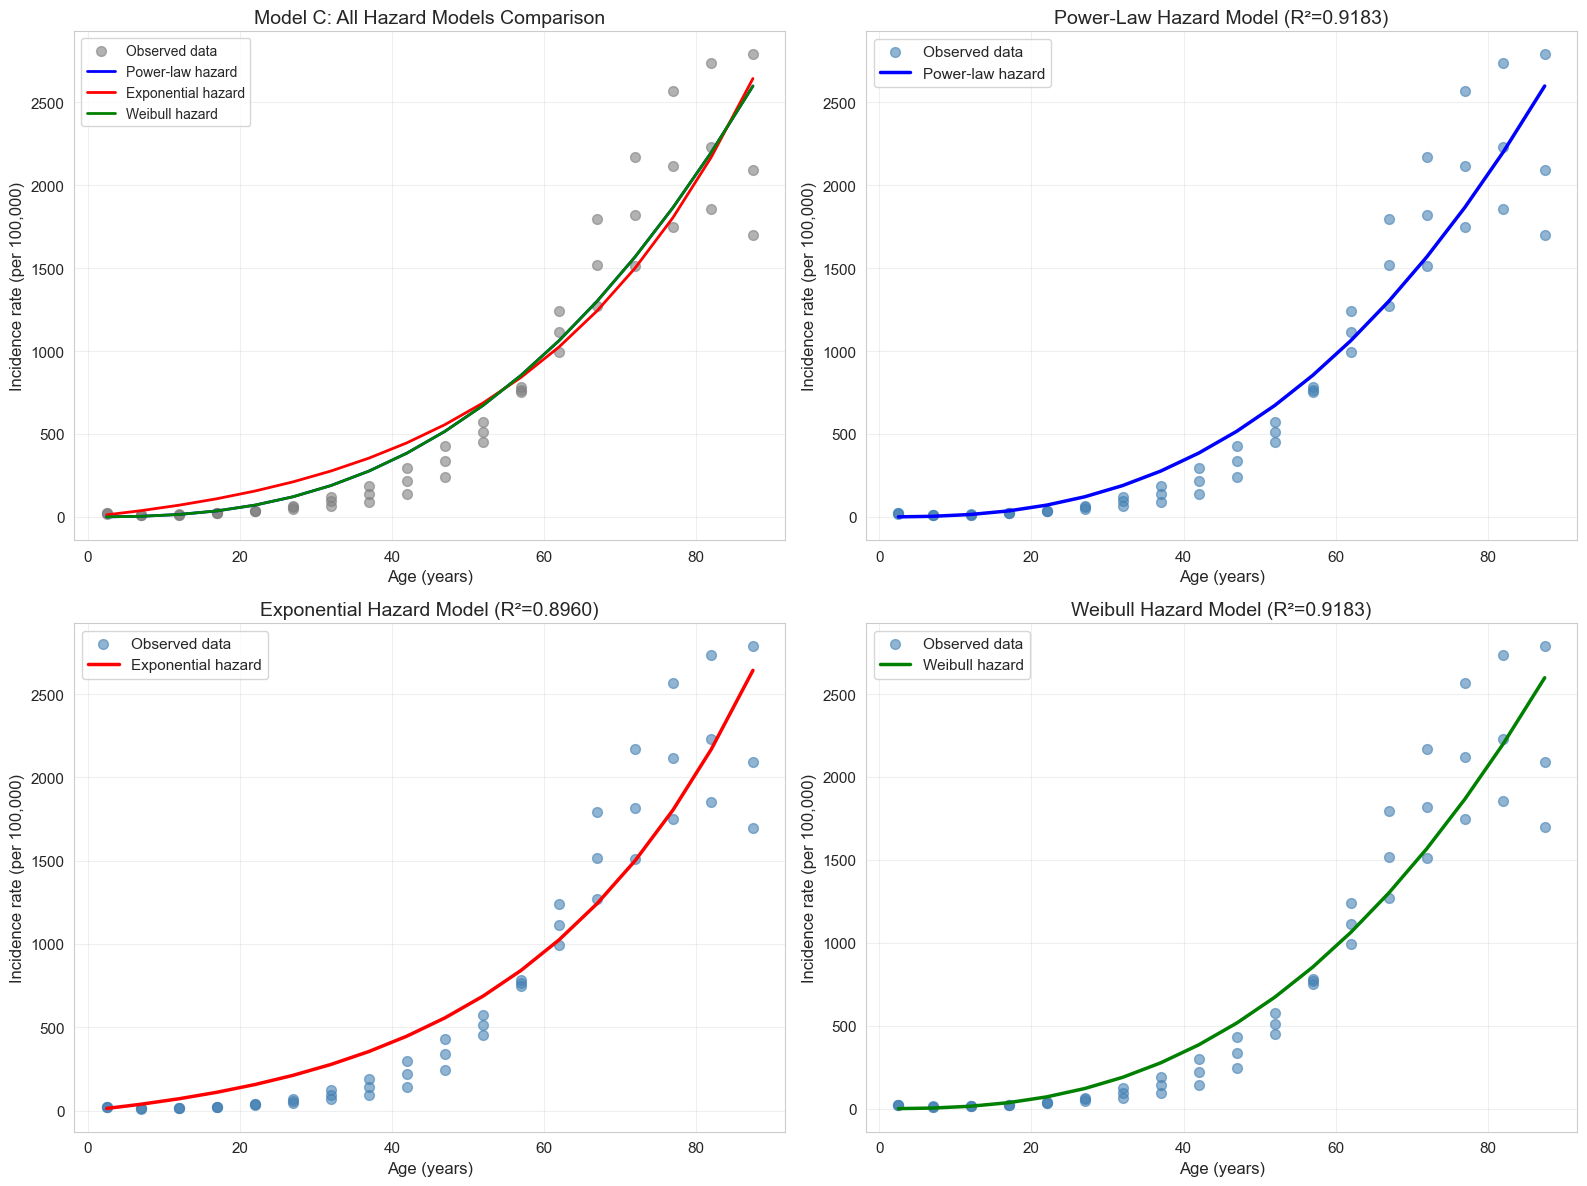

In [8]:
# Create comparison plot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Extract R² values to avoid quote issues
r2_power = results['power_law']['r2']
r2_exp = results['exponential']['r2']
r2_weibull = results['weibull']['r2']

# Plot 1: All models comparison
ax = axes[0, 0]
ax.scatter(ages, rates, alpha=0.6, s=50, color='gray', 
           label='Observed data', zorder=1)
ax.plot(ages, predicted_power, linewidth=2, color='blue', 
        label='Power-law hazard', zorder=2)
ax.plot(ages, predicted_exp, linewidth=2, color='red', 
        label='Exponential hazard', zorder=2)
ax.plot(ages, predicted_weibull, linewidth=2, color='green', 
        label='Weibull hazard', zorder=2)
ax.set_xlabel('Age (years)', fontsize=12)
ax.set_ylabel('Incidence rate (per 100,000)', fontsize=12)
ax.set_title('Model C: All Hazard Models Comparison', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 2: Power-law model
ax = axes[0, 1]
ax.scatter(ages, rates, alpha=0.6, s=50, color='steelblue', 
           label='Observed data', zorder=2)
ax.plot(ages, predicted_power, linewidth=2.5, color='blue', 
        label='Power-law hazard', zorder=3)
ax.set_xlabel('Age (years)', fontsize=12)
ax.set_ylabel('Incidence rate (per 100,000)', fontsize=12)
ax.set_title(f'Power-Law Hazard Model (R²={r2_power:.4f})', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Plot 3: Exponential model
ax = axes[1, 0]
ax.scatter(ages, rates, alpha=0.6, s=50, color='steelblue', 
           label='Observed data', zorder=2)
ax.plot(ages, predicted_exp, linewidth=2.5, color='red', 
        label='Exponential hazard', zorder=3)
ax.set_xlabel('Age (years)', fontsize=12)
ax.set_ylabel('Incidence rate (per 100,000)', fontsize=12)
ax.set_title(f'Exponential Hazard Model (R²={r2_exp:.4f})', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Plot 4: Weibull model
ax = axes[1, 1]
ax.scatter(ages, rates, alpha=0.6, s=50, color='steelblue', 
           label='Observed data', zorder=2)
ax.plot(ages, predicted_weibull, linewidth=2.5, color='green', 
        label='Weibull hazard', zorder=3)
ax.set_xlabel('Age (years)', fontsize=12)
ax.set_ylabel('Incidence rate (per 100,000)', fontsize=12)
ax.set_title(f'Weibull Hazard Model (R²={r2_weibull:.4f})', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 7. Residual Analysis for Best Model


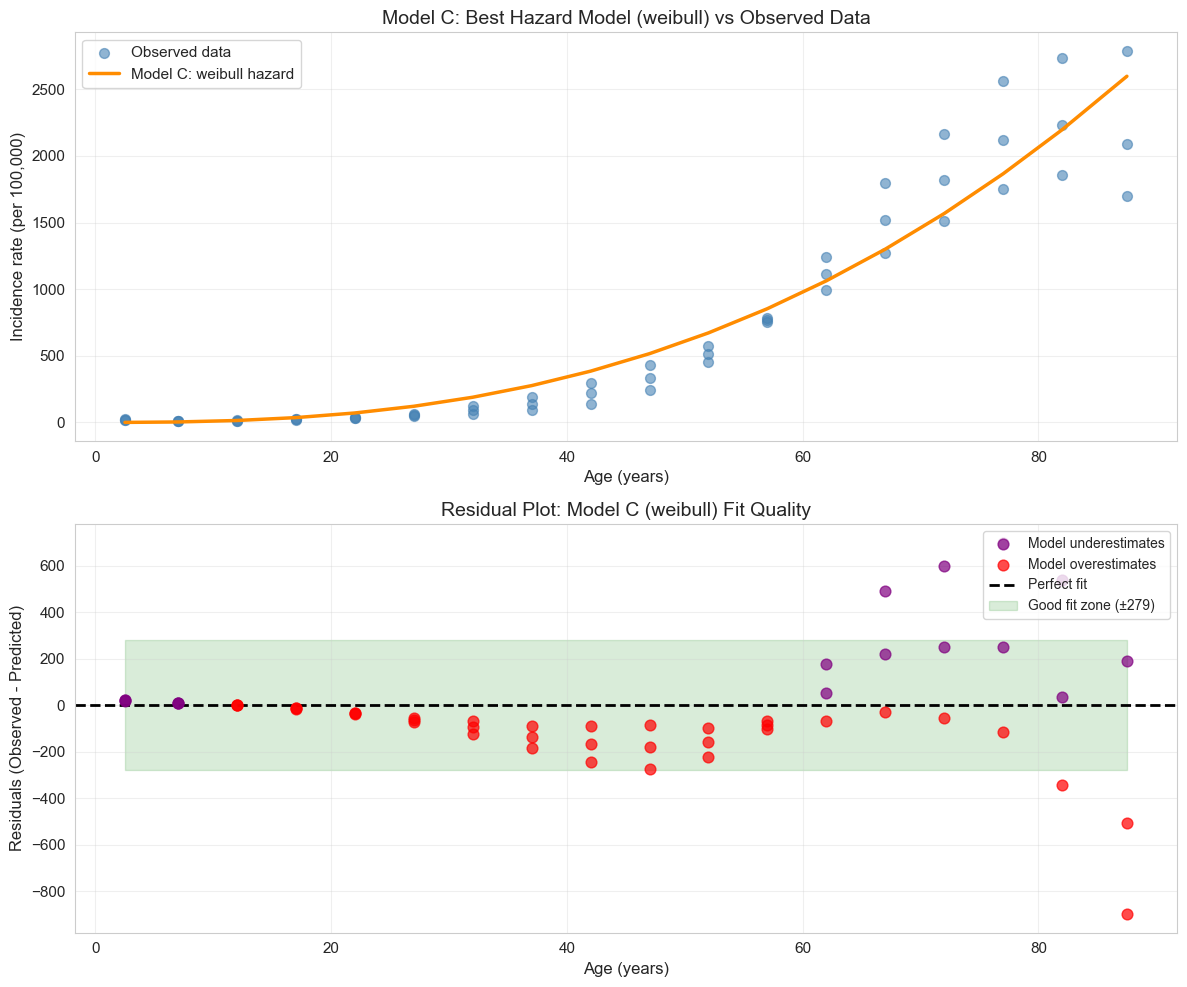


Model C (WEIBULL) Detailed Statistics:
  Mean Squared Error (MSE): 60338.63
  R² Score: 0.9183
  Mean Absolute Error (MAE): 155.94
  Root Mean Squared Error (RMSE): 245.64


In [9]:
# Use best model for detailed residual analysis
best_predicted = results[best_model_name]['predicted']
residuals = rates - best_predicted

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Model fit
axes[0].scatter(ages, rates, alpha=0.6, s=50, color='steelblue',
                label='Observed data', zorder=2)
axes[0].plot(ages, best_predicted, linewidth=2.5, color='darkorange',
             label=f'Model C: {best_model_name} hazard', zorder=3)
axes[0].set_xlabel('Age (years)', fontsize=12)
axes[0].set_ylabel('Incidence rate (per 100,000)', fontsize=12)
axes[0].set_title(f'Model C: Best Hazard Model ({best_model_name}) vs Observed Data', fontsize=14)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot 2: Residuals
positive_mask = residuals >= 0
negative_mask = residuals < 0

axes[1].scatter(ages[positive_mask], residuals[positive_mask],
                alpha=0.7, s=60, color='purple',
                label='Model underestimates', zorder=2)
axes[1].scatter(ages[negative_mask], residuals[negative_mask],
                alpha=0.7, s=60, color='red',
                label='Model overestimates', zorder=2)

axes[1].axhline(y=0, color='black', linestyle='--', linewidth=2,
                label='Perfect fit', zorder=1)

max_rate = np.max(rates)
threshold = 0.1 * max_rate
axes[1].fill_between([ages.min(), ages.max()], -threshold, threshold,
                     alpha=0.15, color='green',
                     label=f'Good fit zone (±{threshold:.0f})', zorder=0)

axes[1].set_xlabel('Age (years)', fontsize=12)
axes[1].set_ylabel('Residuals (Observed - Predicted)', fontsize=12)
axes[1].set_title(f'Residual Plot: Model C ({best_model_name}) Fit Quality', fontsize=14)
axes[1].legend(fontsize=10, loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed statistics
print(f"\n{'='*60}")
print(f"Model C ({best_model_name.upper()}) Detailed Statistics:")
print(f"{'='*60}")
best_stats = results[best_model_name]
print(f"  Mean Squared Error (MSE): {best_stats['mse']:.2f}")
print(f"  R² Score: {best_stats['r2']:.4f}")
print(f"  Mean Absolute Error (MAE): {best_stats['mae']:.2f}")
print(f"  Root Mean Squared Error (RMSE): {best_stats['rmse']:.2f}")


## 8. Summary and Notes

### Model C Characteristics:

1. **Deterministic hazard approach**: Uses continuous hazard functions to model instantaneous risk
2. **Multiple hazard forms**: Implements power-law, exponential, and Weibull hazard functions
3. **Cumulative risk**: Converts hazard to cumulative incidence via survival analysis framework
4. **Official library**: Uses **lifelines** library for Weibull and Exponential models (official implementation)

### Model Types:

- **Power-law hazard**: $h(t) = \\lambda t^k$ - Suitable for accelerating risk (custom scipy implementation)
- **Exponential hazard**: $h(t) = \\lambda e^{\\beta t}$ - Uses **lifelines.ExponentialFitter** when available
- **Weibull hazard**: Uses **lifelines.WeibullFitter** (official implementation) - Flexible parametric form commonly used in survival analysis

### Implementation Details:

- **Weibull and Exponential models**: Use `lifelines` library (official survival analysis library for Python)
- **Power-law model**: Uses custom scipy-based implementation (no standard library available)
- **Fallback**: If lifelines is not available, falls back to scipy-based implementations

### Limitations:

1. **Empirical fitting**: Parameters are fitted to data rather than derived from biological mechanisms
2. **No tissue-specificity**: Currently uses aggregate data
3. **Cox regression**: Full implementation could include Cox proportional hazards regression using lifelines

### Next Steps:

- Extend to tissue-specific analysis using real USCS data
- Compare with Model A (probabilistic) and Model B (replicative-risk)
- Consider implementing Cox regression using `lifelines.CoxPHFitter` for more sophisticated modeling
